In [1]:
import shap
import torch
from torch import nn
import json
from torchmetrics import R2Score
import numpy as np

In [2]:
name = "Protected"

In [3]:
# inputSize = 573 # All
inputSize = 14 # Protected
# inputSize = 559 # Not Protected
net = nn.Sequential(nn.Linear(inputSize, 2048),
                    nn.LeakyReLU(),
                    nn.Linear(2048, 1024),
                    nn.LeakyReLU(),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(),
                    nn.Linear(256, 128),
                    nn.LeakyReLU(),
                    nn.Linear(128, 64),
                    nn.LeakyReLU(),
                    nn.Linear(64,32),
                    nn.LeakyReLU(),
                    nn.Linear(32,1))

In [4]:
net.load_state_dict(torch.load("../trained_models/1680507726-1024-14-ProtectedFields-BEST.pt"))

<All keys matched successfully>

In [5]:
testSetX = torch.load(f"../dataset/testSetX{name}.pt")
testSetY = torch.load(f"../dataset/testSetY{name}.pt")
# testSetX = testSetX.to(device)
# testSetY = testSetY.to(device)
print(testSetX.shape)
print(testSetY.shape)

torch.Size([217324, 14])
torch.Size([217324])


In [6]:
trainSetX = torch.load(f"../dataset/trainSetX{name}.pt")
trainSetY = torch.load(f"../dataset/trainSetY{name}.pt")

In [7]:
with open (f"../dataset/columns{name}.json", "r") as f:
	columns = json.load(f)

In [8]:

net = net.eval()

with torch.no_grad():
	pred = net(testSetX)
	print(pred.shape)

pred = pred.squeeze(1)


torch.Size([217324, 1])


In [9]:

l1Loss = nn.L1Loss()

print(l1Loss(pred, testSetY))

tensor(22348.2656)


In [10]:
print(pred.shape)
print(testSetY.shape)
r2score = R2Score()
r2score(pred, testSetY)
r2score = r2score.compute()
print(r2score)

torch.Size([217324])
torch.Size([217324])
tensor(0.1008)


In [11]:
pred_np = pred.numpy()
testY_np = testSetY.numpy()
testSetX_np = testSetX.numpy()
print(pred_np.shape)
print(testY_np.shape)
print(testSetX_np.shape)

(217324,)
(217324,)
(217324, 14)


In [12]:

# save numpy array as .npy file
with open(f"../dataset/pred{name}.npy", "wb") as f:
    np.save(f, pred_np)

with open(f"../dataset/testY{name}.npy", "wb") as f:
	np.save(f, testY_np)

with open(f"../dataset/testX{name}.npy", "wb") as f:
	np.save(f, testSetX_np)


In [13]:
# Use the DeepExplainer to explain the model
torch.set_grad_enabled(True)
background = trainSetX
e = shap.DeepExplainer(net, trainSetX[:100])

In [14]:
shap_values = e.shap_values(testSetX)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [15]:
print(shap_values.shape)
with open(f"../dataset/shap_values_{name}.npy", "wb") as f:
	np.save(f, shap_values)

(217324, 14)


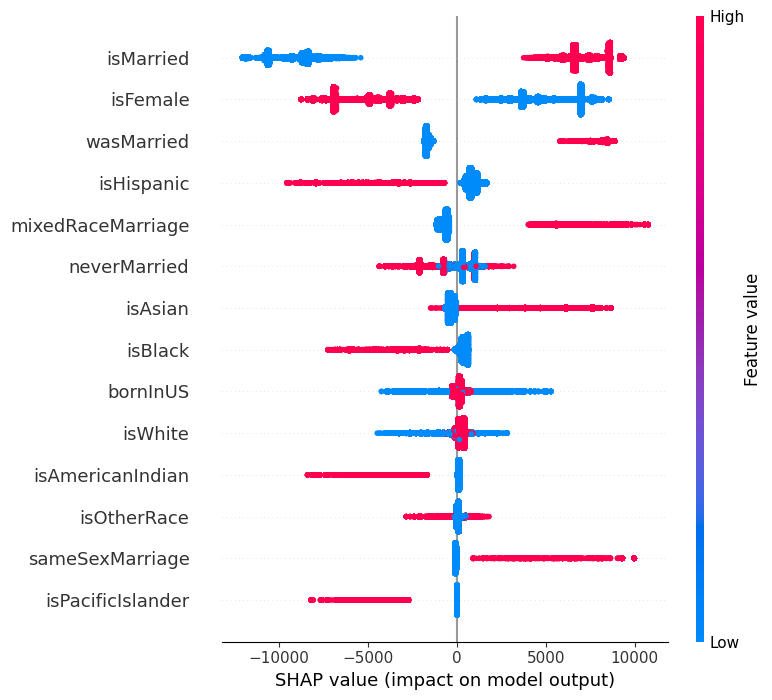

In [16]:
for i in range(0, len(columns)):
    if columns[i].find("occupation_") != -1:
        columns[i] = columns[i][11:]
    columns[i] = columns[i][:20]

shap.summary_plot(shap_values, testSetX, feature_names=columns)

In [ ]:
shap.